In [29]:
import os

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba as nb

import numba.cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

In [74]:
@nb.cuda.jit(device=True)
def diverges(x, y):
    c = np.complex64(x) + np.complex64(y)*np.complex64(1j)
    z = np.complex64(0)
    for _ in range(20):
        z = z*z + c                     # complex z**2 is much slower than z*z
        if z.real**2 + z.imag**2 > 4:   # but real-valued **2 is fine
            return True
    return False

In [75]:
@nb.cuda.jit
def fill_pixel(pixels, xmin, dx, ymin, dy):
    i, j = nb.cuda.grid(2)
    if i < pixels.shape[0] and j < pixels.shape[1]:
        pixels[i, j] = 0 if diverges(xmin + i*dx, ymin + j*dy) else 1

In [111]:
xmin, xmax, ymin, ymax = -2, 0.7, -1.2, 1.2

pixels = cp.empty((3000, 3000), np.float32)
dx = (xmax - xmin) / pixels.shape[0]
dy = (ymax - ymin) / pixels.shape[1]

fill_pixel[(int(np.ceil(pixels.shape[0] / 32)), int(np.ceil(pixels.shape[1] / 32))), (32, 32)](pixels, xmin, dx, ymin, dy)

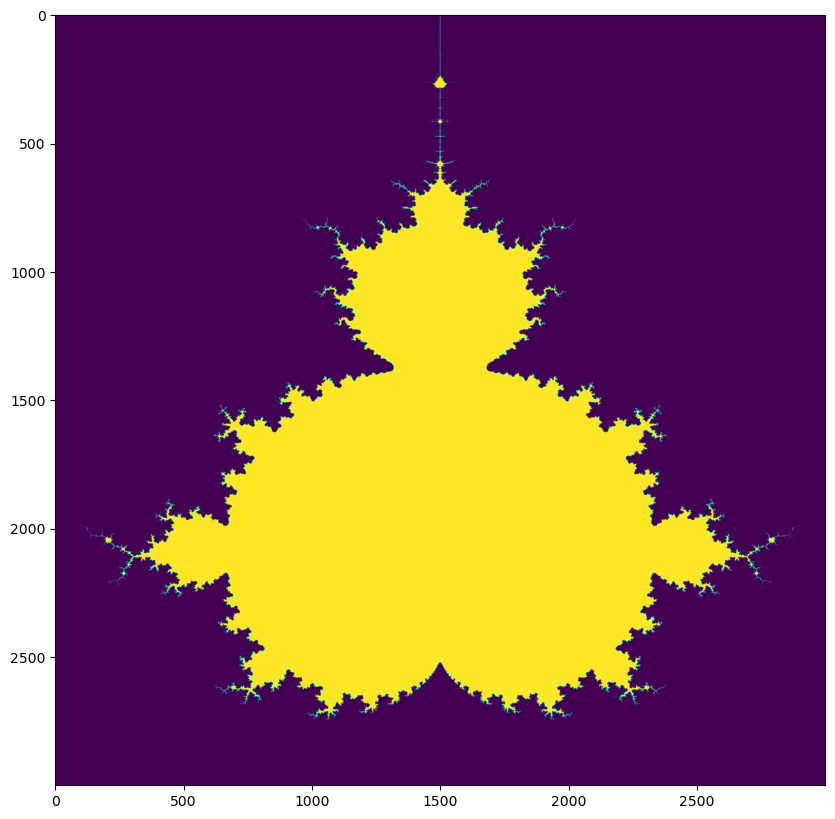

In [113]:
fix, ax = plt.subplots(figsize=(10, 10))
ax.imshow(pixels.get());

In [145]:
@nb.cuda.jit
def count_members(rng_states, num_trials, num_in_set):
    thread_idx = nb.cuda.grid(1)
    for _ in range(num_trials):
        x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
        y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
        if x**2 + y**2 < 1:
            num_in_set[thread_idx] += 1

In [150]:
def area(num_total_trials):
    num_threads = 1024
    num_blocks = 1024
    num_trials = num_total_trials // (num_threads * num_blocks)
    assert num_trials > 0
    assert num_trials * num_threads * num_blocks == num_total_trials

    starting_seed = np.frombuffer(os.urandom(8), dtype=np.int64)[0]
    rng_states = create_xoroshiro128p_states(num_threads * num_blocks, seed=starting_seed)

    num_in_set = cp.zeros(num_threads * num_blocks, dtype=np.uint64)

    count_members[num_blocks, num_threads](rng_states, num_trials, num_in_set)

    fraction_of_area = num_in_set.sum() / num_total_trials
    return fraction_of_area

In [151]:
area(100*1024**2)

array(0.7854041)